In [1]:
import os
import qutip as qt
from qutip import *
import numpy as np
from joblib import Parallel, delayed
from scipy.linalg import *
import os
import shutil
# from multiprocessing import Process
from pathlib import Path
from tqdm import tqdm
import pickle
import scipy.sparse as sps
import scipy.sparse.linalg as spsla

import importlib
import general_functions
# import sBs_noise_analysis
import plotsmodule
import metrology_noise
import bits
# import sBs
import backaction_noise
importlib.reload(general_functions)
# importlib.reload(sBs_noise_analysis)
importlib.reload(plotsmodule)
importlib.reload(metrology_noise)
importlib.reload(bits)
importlib.reload(backaction_noise)
# importlib.reload(sBs)
# from sBs import *
from general_functions import *
from plotsmodule import *
from metrology_noise import *
from bits import *
# from sBs_noise_analysis import *

In [2]:
cwd = os.getcwd()
path_sbs_noise = os.path.dirname(cwd)
path_sbs_noise_results = path_sbs_noise + "/Results/"
path_sbs_noise_results_qorppath = path_sbs_noise_results + "/q_or_p_bitstring_paths/"
path_sbs_noise_results_steady = path_sbs_noise_results + "/Input_states/"
path_sbs_noise_results_exact = path_sbs_noise_results + "/exact/"
path_sbs_noise_results_eachnoise = path_sbs_noise_results + "/eachnoise/"
path_sbs_noise_params = path_sbs_noise + "/Params_files/"
path_sbs_noise_params_qorppaths = path_sbs_noise_params + "/q_or_p_bitstring_paths/"
path_sbs_noise_params_steady = path_sbs_noise_params + "/steady_state_params/"
path_sbs_noise_params_exact = path_sbs_noise_params + "/exact/"
path_sbs_noise_params_eachnoise = path_sbs_noise_params + "/eachnoise/"
path_sbs_noise_figures = path_sbs_noise + "/Figures/"
path_GKP = os.path.dirname(path_sbs_noise)
path_sBs_noiseless = path_GKP + "/sBs-noiseless/"
path_sBs_bayesian = path_sBs_noiseless+"data/bayesian/"
path_figures = path_sBs_noiseless+"/figures/"
path_figures_data = path_figures + "/data/"
os.makedirs(path_sbs_noise_figures, exist_ok=True)
print(path_sBs_bayesian)

/Users/labl2714/Projects/GKP-metrology/GKP-metrology/sBs-noiseless/data/bayesian/


# Load sBs functions

In [ ]:
# #define operators
# N = 140 #fix fock dimension
# l = np.sqrt(2*np.pi)
# I = sps.csc_matrix(np.eye(N))
# a_op = qt.destroy(N)
# n_op = a_op.dag()*a_op
# a_op = sps.csc_matrix(a_op.full())
# n_op = sps.csc_matrix(n_op.full())
# q_op = (a_op + a_op.T)/np.sqrt(2)
# p_op = -1j*(a_op - a_op.T)/np.sqrt(2)
# ket_vacuum = sps.csc_matrix(qt.basis(N,0).full())
# rho_vacuum = qt.ket2dm(qt.basis(N,0)).full()
# rho_vacuum = sps.csc_matrix(rho_vacuum)
# Tp = spsla.expm(1j*l*p_op)
# Tq = spsla.expm(1j*l*q_op)
# Dict_T = {'T1':Tq,'T2':Tp}

# sigma_x = sps.csc_matrix(qt.sigmax().full())
# sigma_z = sps.csc_matrix(qt.sigmaz().full())
# ket_0 = qt.basis(2,1).full()#g
# ket_1 = qt.basis(2,0).full()#e
# rho_g = sps.csc_matrix(qt.ket2dm(qt.basis(2,1)).full())
# rho_e = sps.csc_matrix(qt.ket2dm(qt.basis(2,0)).full())
# ket_plus = sps.csc_matrix((ket_0 + ket_1)/np.sqrt(2))
# ket_minus = sps.csc_matrix((ket_0 - ket_1)/np.sqrt(2))
# rho_plus = sps.csc_matrix(qt.ket2dm(qt.basis(2,0)+qt.basis(2,1)).full())/2
# rho_minus = sps.csc_matrix(qt.ket2dm(qt.basis(2,1)-qt.basis(2,0)).full())/2
# I_ket_g = sps.kron(I,ket_0)
# I_ket_e = sps.kron(I,ket_1)
# I_ket_plus = sps.kron(I,ket_plus)

# rho_vacuum_plus = sps.kron(rho_vacuum,ket_plus)
# rho_vacuum_g = sps.kron(rho_vacuum,ket_0)
# rho_vacuum_e = sps.kron(rho_vacuum,ket_1)


# #basic functions
# def Displacement(alpha):
#     return sps.csc_matrix(spsla.expm(alpha*a_op.T - alpha.conjugate()*a_op))
# def CD(alpha):
#     return spsla.expm(sps.kron(alpha*a_op.T - alpha.conjugate()*a_op,sigma_z/2/np.sqrt(2)))
# def Krauss_from_U(U):
#     #U acts on the system and ancilla
#     #assumme qubit starts on |+>
#     Kg = sps.csc_matrix(I_ket_g.getH() @ U @ I_ket_plus)
#     Ke = sps.csc_matrix(I_ket_e.getH() @ U @ I_ket_plus)
#     Kg.data[np.abs(Kg.data) < 1e-7] = 0
#     Ke.data[np.abs(Ke.data) < 1e-7] = 0
#     Kg.eliminate_zeros()
#     Ke.eliminate_zeros()
#     return Kg.tocsc(), Ke.tocsc()

# def stabilizers(Delta):
#     E = spsla.expm(-Delta**2*n_op)
#     E_inv = spsla.inv(E.tocsc())
#     Tq, Tp = Dict_T['T1'], Dict_T['T2']
#     return E@Tq@E_inv, E@Tp@E_inv

# def displaced_stabilizers(Tq_delta, Tp_delta,alpha):
#     # T a stabilizer in sp.csc_matrix form, alpha a complex number
#     # returns displaced stabilizer
#     D = Displacement(alpha)
#     return D@Tq_delta@D.getH(), D@Tp_delta@D.getH()

# def I_Rx(theta):
#     Rx = np.array([[np.cos(theta/2),-1j*np.sin(theta/2)],[-1j*np.sin(theta/2),np.cos(theta/2)]])
#     return sps.kron(I,sps.csc_matrix(Rx))


# #sBs with reset
# def sBs_p(mu,Delta):
#     #corresponds to pg \simeq (1-nu\sin(lp))/2
#     sd, cd, td = np.sinh(Delta**2), np.cosh(Delta**2), np.tanh(Delta**2)
#     large, small = l*cd, 1j*l*sd/2
#     nu = (-1)**mu
#     return CD(small)@I_Rx(nu*np.pi/2)@CD(large)@I_Rx(np.pi/2)@CD(small)
# def sBs_q(mu,Delta):
#     #corresponds to pg \simeq (1-nu\sin(lq))/2
#     sd, cd, td = np.sinh(Delta**2), np.cosh(Delta**2), np.tanh(Delta**2)
#     large, small = -1j*l*cd, l*sd/2
#     nu = (-1)**mu
#     return CD(small)@I_Rx(-nu*np.pi/2)@CD(large)@I_Rx(np.pi/2)@CD(small)

# def sBs_p_measurement(mu,Delta):
#     #corresponds to pg \simeq (1-nu\sin(lp))/2
#     sd, cd, td = np.sinh(Delta**2), np.cosh(Delta**2), np.tanh(Delta**2)
#     large, small = l*cd, 1j*l*sd/2
#     nu = (-1)**mu
#     return I_Rx(-nu*np.pi/2)@CD(large)@I_Rx(np.pi/2)@CD(small)
# def sBs_q_measurement(mu,Delta):
#     #corresponds to pg \simeq (1-nu\sin(lq))/2
#     sd, cd, td = np.sinh(Delta**2), np.cosh(Delta**2), np.tanh(Delta**2)
#     large, small = -1j*l*cd, l*sd/2
#     nu = (-1)**mu
#     return I_Rx(-nu*np.pi/2)@CD(large)@I_Rx(np.pi/2)@CD(small)

# def Krauss_dictionaries(Delta):
#     Uq0, Uq1  = sBs_q_measurement(0,Delta), sBs_q_measurement(1,Delta)
#     Up0, Up1 = sBs_p_measurement(0,Delta), sBs_p_measurement(1,Delta)

#     cd, sd = np.cosh(Delta**2), np.sinh(Delta**2)
#     small_p = (1j*l*sd/2)/2/np.sqrt(2)
#     small_q = (l*sd/2)/2/np.sqrt(2)
#     Uqe, Uqg = Displacement(small_q), Displacement(-small_q)
#     Upe, Upg = Displacement(small_p), Displacement(-small_p)

#     Kgq0, Keq0 = Krauss_from_U(Uq0)
#     Kgq1, Keq1 = Krauss_from_U(Uq1)
#     Kgp0, Kep0 = Krauss_from_U(Up0)
#     Kgp1, Kep1 = Krauss_from_U(Up1)
#     Krauss_dictionary = {'Kgq0':Kgq0,'Keq0':Keq0,'Kgq1':Kgq1,'Keq1':Keq1,'Kgp0':Kgp0,'Kep0':Kep0,'Kgp1':Kgp1,'Kep1':Kep1}
#     Krauss_dictionary_U = {'Kgq0':Uqg @ Kgq0,'Keq0':Uqe @ Keq0,'Kgq1':Uqg @ Kgq1,'Keq1':Uqe @ Keq1,'Kgp0':Upg @ Kgp0,'Kep0':Upe @ Kep0,'Kgp1':Upg @ Kgp1,'Kep1':Upe @ Kep1}
#     return Krauss_dictionary, Krauss_dictionary_U

# def sBs_cycle(Delta,R,rho0,gauges):
#     #R is the number of q-p cycles
#     #rho0 the initial state of the oscillator 
#     #returns all density matrices and probabilities. Length of the list is R+1.

#     Krauss_dictionary, Krauss_dictionary_U = Krauss_dictionaries(Delta)
#     rho = rho0.copy()
#     rhos = [rho.copy()]
#     mu_q, mu_p = gauges[0], gauges[1] #initialize the gauges, this assures final preparation of sensor in 0,0 when starting in vacuum. 
#     probs_gq, probs_gp = [], []
#     for i in range(R):
#         Kgq, Keq = Krauss_dictionary_U[f'Kgq{mu_q}'], Krauss_dictionary_U[f'Keq{mu_q}']
#         probs_gq.append((Kgq.getH()@Kgq@rho).diagonal().sum())
#         rho = Kgq @ rho @ Kgq.getH() + Keq @rho @ Keq.getH()     
#         mu_p = (mu_p +1)% 2#gauge update
        
#         Kgp, Kep = Krauss_dictionary_U[f'Kgp{mu_p}'], Krauss_dictionary_U[f'Kep{mu_p}']
#         probs_gp.append((Kgp.getH()@Kgp@rho).diagonal().sum())
#         rho = Kgp @ rho @ Kgp.getH() + Kep @rho @ Kep.getH()
#         mu_q = (mu_q +1)% 2
#         rhos.append(rho.copy())
    
#     return rhos, np.real(probs_gq), np.real(probs_gp)

# def sBs_cycle_finalrho(Delta,R,sensor,gauges,q0,p0):
#     #R is the number of q-p cycles
#     #rho0 the initial state of the oscillator 
#     #returns all density matrices and probabilities. Length of the list is R+1.

#     beta = (q0 + 1j*p0)/np.sqrt(2)
#     U_q0p0 = Displacement(beta)
#     rho = U_q0p0 @ sensor @ U_q0p0.getH()

#     Krauss_dictionary, Krauss_dictionary_U = Krauss_dictionaries(Delta)
#     mu_q, mu_p = gauges[0], gauges[1] #initialize the gauges, this assures final preparation of sensor in 0,0 when starting in vacuum. 
#     probs_gq, probs_gp = [], []
#     for i in range(R):
#         Kgq, Keq = Krauss_dictionary_U[f'Kgq{mu_q}'], Krauss_dictionary_U[f'Keq{mu_q}']
#         rho = Kgq @ rho @ Kgq.getH() + Keq @rho @ Keq.getH()     
#         mu_p = (mu_p +1)% 2#gauge update
        
#         Kgp, Kep = Krauss_dictionary_U[f'Kgp{mu_p}'], Krauss_dictionary_U[f'Kep{mu_p}']
#         rho = Kgp @ rho @ Kgp.getH() + Kep @rho @ Kep.getH()
#         mu_q = (mu_q +1)% 2
#     return rho 


# Bit flip analysis

### state preparation

In [ ]:
# sensor = qt.qload("../Input_states/sensor_state_delta-30-Nc140")
# sensor = sps.csc_matrix(sensor.full())
import sBs
from sBs import *

Delta = 0.3
rhos, probs_q, probs_p = sBs_cycle(Delta, 120, rho_vacuum, [0, 0])
sensor = rhos[-1]  # Final state after the cycles

/Users/labl2714/Projects/GKP-metrology/GKP_noise/lib/python3.10/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  return spsolve(Q, P)
/Users/labl2714/Projects/GKP-metrology/GKP_noise/lib/python3.10/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
/Users/labl2714/Projects/GKP-metrology/GKP_noise/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:602: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve


In [6]:
xvec = np.arange(-2*l,2*l,0.05)
W = qt.wigner(qt.Qobj(sensor), xvec, xvec)

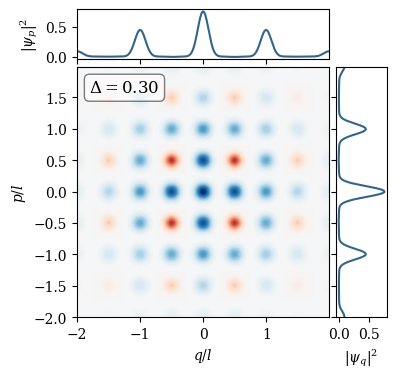

In [7]:
# Assuming W, xvec, and l are already defined
row_marginal = np.sum(W, axis=0)*(xvec[1]-xvec[0])
column_marginal = np.sum(W, axis=1)*(xvec[1]-xvec[0])

# Normalize the color scale
nrm = mpl.colors.Normalize(-W.max(), W.max())

# Create the main plot and the marginal plots
fig = plt.figure(figsize=(4, 4))
gs = fig.add_gridspec(2, 2, width_ratios=(5, 1), height_ratios=(1, 5), hspace=0.05, wspace=0.05)

# Main contour plot
ax_main = fig.add_subplot(gs[1, 0])
contour = ax_main.contourf(xvec/l, xvec/l, W, 100, cmap=cm.RdBu, norm=nrm)
ax_main.set_xlabel(r'$q/l$')
ax_main.set_ylabel(r'$p/l$')

# Row marginal plot
ax_row = fig.add_subplot(gs[0, 0], sharex=ax_main)
ax_row.plot(xvec/l, row_marginal, color=blue)
ax_row.set_ylabel(r'$|\psi_p|^2$')
ax_row.xaxis.set_tick_params(labelbottom=False)

# Column marginal plot
ax_col = fig.add_subplot(gs[1, 1], sharey=ax_main)
ax_col.plot(column_marginal, xvec/l, color=blue)
ax_col.set_xlabel(r'$|\psi_q|^2$')
ax_col.yaxis.set_tick_params(labelleft=False)

# Add textbox with the value of Delta
Delta = 0.3
textstr = r'$\Delta = {0:.2f}$'.format(Delta)

props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax_main.text(0.05, 0.95, textstr, transform=ax_main.transAxes, fontsize=12,
             verticalalignment='top', bbox=props)

plt.show()

## bitflip in sBs

### simplest

In [10]:
def sBs_q_bitflips(mu, Delta):
    sd, cd, td = np.sinh(Delta**2), np.cosh(Delta**2), np.tanh(Delta**2)
    large, small = -1j*l*cd, l*sd/2
    nu = (-1)**mu
    return CD(small)@I_Rx(-nu*np.pi/2)@CD(-large)@I_Rx(np.pi/2)@CD(small)

Uq0_bf, Uq1_bf = sBs_q_bitflips(0, Delta), sBs_q_bitflips(1, Delta)
Kgq0_bf, Keq0_bf = Krauss_from_U(Uq0_bf)
Kgq1_bf, Keq1_bf = Krauss_from_U(Uq1_bf)

Krauss_dictionary, Krauss_dictionary_U = Krauss_dictionaries(Delta)
Kgq0, Keq0 = Krauss_dictionary_U['Kgq0'], Krauss_dictionary_U['Keq0']

# print(np.round(qt.Qobj(Kgq0-Keq0).eigenenergies(),3))

rho_ok = qt.Qobj(Kgq0 @ sensor @ Kgq0.getH()+ Keq0 @ sensor @ Keq0.getH()) 
rho_bf = qt.Qobj(Kgq0_bf @ sensor @ Kgq0_bf.getH() + Keq0_bf @ sensor @ Keq0_bf.getH())
rho_ok = rho_ok/ rho_ok.tr()
rho_bf = rho_bf/ rho_bf.tr()
print('fidelity:', qt.fidelity(qt.Qobj(rho_ok), qt.Qobj(rho_bf)))

xvec = np.arange(-2*l, 2*l, 0.05)
W_ok = qt.wigner(qt.Qobj(rho_ok), xvec, xvec)
W_bf = qt.wigner(qt.Qobj(rho_bf), xvec, xvec)

fidelity: 0.8637895359939959


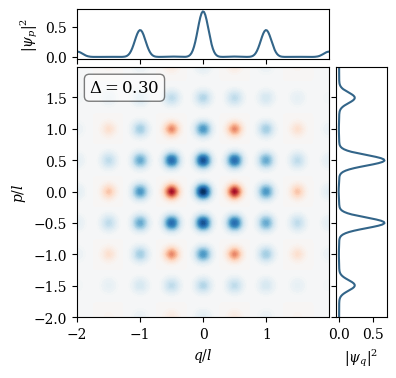

In [11]:
# Assuming W, xvec, and l are already defined
row_marginal = np.sum(W_ok, axis=0)*(xvec[1]-xvec[0])
column_marginal = np.sum(W_ok, axis=1)*(xvec[1]-xvec[0])

# Normalize the color scale
nrm = mpl.colors.Normalize(-W_ok.max(), W_ok.max())

# Create the main plot and the marginal plots
fig = plt.figure(figsize=(4, 4))
gs = fig.add_gridspec(2, 2, width_ratios=(5, 1), height_ratios=(1, 5), hspace=0.05, wspace=0.05)

# Main contour plot
ax_main = fig.add_subplot(gs[1, 0])
contour = ax_main.contourf(xvec/l, xvec/l, W_ok, 100, cmap=cm.RdBu, norm=nrm)
ax_main.set_xlabel(r'$q/l$')
ax_main.set_ylabel(r'$p/l$')

# Row marginal plot
ax_row = fig.add_subplot(gs[0, 0], sharex=ax_main)
ax_row.plot(xvec/l, row_marginal, color=blue)
ax_row.set_ylabel(r'$|\psi_p|^2$')
ax_row.xaxis.set_tick_params(labelbottom=False)

# Column marginal plot
ax_col = fig.add_subplot(gs[1, 1], sharey=ax_main)
ax_col.plot(column_marginal, xvec/l, color=blue)
ax_col.set_xlabel(r'$|\psi_q|^2$')
ax_col.yaxis.set_tick_params(labelleft=False)

# Add textbox with the value of Delta
Delta = 0.3
textstr = r'$\Delta = {0:.2f}$'.format(Delta)

props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax_main.text(0.05, 0.95, textstr, transform=ax_main.transAxes, fontsize=12,
             verticalalignment='top', bbox=props)

plt.show()

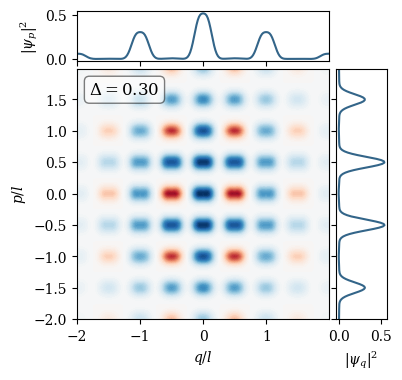

In [12]:
# Assuming W, xvec, and l are already defined
row_marginal = np.sum(W_bf, axis=0)*(xvec[1]-xvec[0])
column_marginal = np.sum(W_bf, axis=1)*(xvec[1]-xvec[0])

# Normalize the color scale
nrm = mpl.colors.Normalize(-W_bf.max(), W_bf.max())

# Create the main plot and the marginal plots
fig = plt.figure(figsize=(4, 4))
gs = fig.add_gridspec(2, 2, width_ratios=(5, 1), height_ratios=(1, 5), hspace=0.05, wspace=0.05)

# Main contour plot
ax_main = fig.add_subplot(gs[1, 0])
contour = ax_main.contourf(xvec/l, xvec/l, W_bf, 100, cmap=cm.RdBu, norm=nrm)
ax_main.set_xlabel(r'$q/l$')
ax_main.set_ylabel(r'$p/l$')

# Row marginal plot
ax_row = fig.add_subplot(gs[0, 0], sharex=ax_main)
ax_row.plot(xvec/l, row_marginal, color=blue)
ax_row.set_ylabel(r'$|\psi_p|^2$')
ax_row.xaxis.set_tick_params(labelbottom=False)

# Column marginal plot
ax_col = fig.add_subplot(gs[1, 1], sharey=ax_main)
ax_col.plot(column_marginal, xvec/l, color=blue)
ax_col.set_xlabel(r'$|\psi_q|^2$')
ax_col.yaxis.set_tick_params(labelleft=False)

# Add textbox with the value of Delta
Delta = 0.3
textstr = r'$\Delta = {0:.2f}$'.format(Delta)

props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax_main.text(0.05, 0.95, textstr, transform=ax_main.transAxes, fontsize=12,
             verticalalignment='top', bbox=props)

plt.show()

### bitflip in all points

In [13]:
def sBs_q_bitflips(mu, Delta, beta):
    #beta in -1 to 1
    sd, cd, td = np.sinh(Delta**2), np.cosh(Delta**2), np.tanh(Delta**2)
    large, small = -1j*l*cd, l*sd/2
    nu = (-1)**mu
    return CD(small)@I_Rx(-nu*np.pi/2)@CD(beta * large)@I_Rx(np.pi/2)@CD(small)
    
def fidelity_after_bitflip(sensor, Delta,beta):
    
    Uq0_bf, Uq1_bf = sBs_q_bitflips(0, Delta,beta), sBs_q_bitflips(1, Delta,beta)
    Kgq0_bf, Keq0_bf = Krauss_from_U(Uq0_bf)
    Kgq1_bf, Keq1_bf = Krauss_from_U(Uq1_bf)

    Krauss_dictionary, Krauss_dictionary_U = Krauss_dictionaries(Delta)
    Kgq0, Keq0 = Krauss_dictionary_U['Kgq0'], Krauss_dictionary_U['Keq0']

    # print(np.round(qt.Qobj(Kgq0-Keq0).eigenenergies(),3))

    rho_ok_g = qt.Qobj(Kgq0 @ sensor @ Kgq0.getH())
    rho_ok_e = qt.Qobj(Keq0 @ sensor @ Keq0.getH())
    rho_bf_g = qt.Qobj(Kgq0_bf @ sensor @ Kgq0_bf.getH())
    rho_bf_e = qt.Qobj(Keq0_bf @ sensor @ Keq0_bf.getH())
    rho_ok_g = rho_ok_g/ rho_ok_g.tr()
    rho_ok_e = rho_ok_e/ rho_ok_e.tr()
    rho_bf_g = rho_bf_g/ rho_bf_g.tr()
    rho_bf_e = rho_bf_e/ rho_bf_e.tr()

    F_gg = qt.fidelity(qt.Qobj(rho_ok_g), qt.Qobj(rho_bf_g))
    F_ee = qt.fidelity(qt.Qobj(rho_ok_e), qt.Qobj(rho_bf_e))
    F_ge = qt.fidelity(qt.Qobj(rho_ok_g), qt.Qobj(rho_bf_e))
    F_eg = qt.fidelity(qt.Qobj(rho_ok_e), qt.Qobj(rho_bf_g))
    F_bf_ge = qt.fidelity(qt.Qobj(rho_bf_g), qt.Qobj(rho_bf_e))
    F_ok_ge = qt.fidelity(qt.Qobj(rho_ok_g), qt.Qobj(rho_ok_e))
    F_bf_gg = qt.fidelity(qt.Qobj(rho_bf_g), qt.Qobj(rho_bf_g))
    return [F_gg, F_ee, F_ge, F_eg, F_bf_ge, F_ok_ge, F_bf_gg]

beta_range = np.linspace(-1, 1, 100)
fidelities = [fidelity_after_bitflip(sensor, Delta, beta) for beta in tqdm(beta_range)]


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [06:42<00:00,  4.03s/it]


(100, 7)


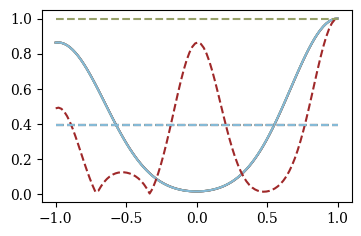

In [14]:
fig, ax = plt.subplots(figsize=(4, 2.5))
fidelities = np.array(fidelities)
print(fidelities.shape)
F_gg = fidelities[:, 0]
F_ee = fidelities[:, 1]
F_ge = fidelities[:, 2]
F_eg = fidelities[:, 3]
F_bf_ge = fidelities[:, 4]
F_ok_ge = fidelities[:, 5]
F_bf_gg = fidelities[:, 6]
ax.plot(beta_range, F_gg, color=blue)
ax.plot(beta_range, F_ee, color=red)
ax.plot(beta_range, F_ge, color=green)
ax.plot(beta_range, F_eg, color=light_blue)
ax.plot(beta_range, F_bf_ge, color=red, linestyle='--', label='bitflip ge')
ax.plot(beta_range, F_ok_ge, color=green, linestyle='--', label='ok ge')
# ax.plot(beta_range, F_bf_gg, color=blue, linestyle='--', label='bitflip gg')
ax.plot(beta_range, np.average(F_gg)*np.ones_like(beta_range), color=blue, linestyle='--', label='average fidelity')
ax.plot(beta_range, np.average(F_ee)*np.ones_like(beta_range), color=red, linestyle='--')
ax.plot(beta_range, np.average(F_ge)*np.ones_like(beta_range), color=green, linestyle='--')
ax.plot(beta_range, np.average(F_eg)*np.ones_like(beta_range), color=light_blue, linestyle='--')

dict_figure = {}
dict_figure['fidelities'] = fidelities
dict_figure['beta_range'] = beta_range
name = 'data-bitflips'
np.savez(path_figures_data+name, **dict_figure)


# relaxation with ME

In [18]:
cavity_T1 = 610
cavity_T2 = 980
qubit_T1 = 70
qubit_T2 = 240
t_cd_B = 0.5
T_1q = round(qubit_T1/ t_cd_B, 5)
T_2q = round(qubit_T2/ t_cd_B, 5)
T_1c = round(cavity_T1/ t_cd_B, 5)
T_2c = round(cavity_T2/ t_cd_B, 5)
T_qphi = 1 / (1 / T_2q - 1 / (2 * T_1q))
T_cphi = 1 / (1 / T_2c - 1 / (2 * T_1c))
N_c = 140
N_q = 2
delta = 0.3
init_state_path =  "../Input_states/sensor_state_delta-{0:.0f}-Nc140".format(delta*100)
sensor = qu.qload(init_state_path)

system_dict = {
    "dimensions": {"qubit": N_q, "cavity": N_c,},
    "operators": {
        "qubit": {
            "sx": qu.sigmax(),
            "sy": qu.sigmay(),
            "sz": qu.sigmaz(),
            "sm": qu.sigmam(),
        },
        "cavity": {"a": qu.destroy(N_c)},
    },
    "state_params": {"l": l, "delta": delta},
    "timings": {"t_B": np.linspace(0, 1.0, 51),},
    "c_ops": [
        qu.tensor(qu.sigmam(), qu.qeye(N_c)) / np.sqrt(T_1q)
    ],
    "simulations": {
        "r": 1,
        # "sensor": qu.qload(
        #     "../Input_states/sensor_state_delta-{}-Nc{}".format(int(100 * delta), N_c)
        # ),
        "sensor": qt.Qobj(sensor),
        'p_0': 0,
    },
}

system_dict_noiseless = {
    "dimensions": {"qubit": N_q, "cavity": N_c,},
    "operators": {
        "qubit": {
            "sx": qu.sigmax(),
            "sy": qu.sigmay(),
            "sz": qu.sigmaz(),
            "sm": qu.sigmam(),
        },
        "cavity": {"a": qu.destroy(N_c)},
    },
    "state_params": {"l": l, "delta": delta},
    "timings": {"t_B": np.linspace(0, 1.0, 51),},
    "c_ops": [],
    "simulations": {
        "r": 1,
        # "sensor": qu.qload(
        #     "../Input_states/sensor_state_delta-{}-Nc{}".format(int(100 * delta), N_c)
        # ),
        "sensor": qt.Qobj(sensor),
        'p_0': 0,
    },
}


g_proj = qu.tensor(
        qu.basis(system_dict["dimensions"]["qubit"], 1)
        * qu.basis(system_dict["dimensions"]["qubit"], 1).dag(),
        qu.qeye(system_dict["dimensions"]["cavity"]),
    )
e_proj = qu.tensor(
    qu.basis(system_dict["dimensions"]["qubit"], 0)
    * qu.basis(system_dict["dimensions"]["qubit"], 0).dag(),
    qu.qeye(system_dict["dimensions"]["cavity"]),
)

# definition of rho_plus = |+><+|
psi_plus = (
    qu.basis(system_dict["dimensions"]["qubit"], 0)
    + qu.basis(system_dict["dimensions"]["qubit"], 1)
) / np.sqrt(2)
rho_plus = psi_plus * psi_plus.dag()

rho = qu.tensor(rho_plus, system_dict["simulations"]["sensor"])
rhoq, pg = sBs_q_evolve(rho, system_dict, 0)
rho_noiseless, pg = sBs_q_evolve(rho, system_dict_noiseless, 0)
rhoq_g = rhoq * g_proj
rhoq_e = rhoq * e_proj
rho_noiseless_g = rho_noiseless * g_proj
rho_noiseless_e = rho_noiseless * e_proj

In [19]:
rhoqg = qt.ptrace(rhoq_g, 1)
rhoqe = qt.ptrace(rhoq_e, 1)
rhog_noiseless = qt.ptrace(rho_noiseless_g, 1)
rhoe_noiseless = qt.ptrace(rho_noiseless_e, 1)
rhoqg = rhoqg / rhoqg.tr()
rhoqe = rhoqe / rhoqe.tr()
rhog_noiseless = rhog_noiseless / rhog_noiseless.tr()
rhoe_noiseless = rhoe_noiseless / rhoe_noiseless.tr()
F_g = qt.fidelity(rhoqg, rhog_noiseless)
F_e = qt.fidelity(rhoqe, rhoe_noiseless)
F_ge = qt.fidelity(rhoq_g, rhoq_e)
F_gg = qt.fidelity(rhoq_g, rhoq_g)

def fidelity(rho1, rho2):
    rho1 = rho1.full()
    rho1_sqrt = sp.linalg.sqrtm(rho1)
    rho2 = rho2.full()
    return sp.linalg.sqrtm(rho1_sqrt @ rho2 @ rho1_sqrt).diagonal().sum()

F_g = fidelity(rhoqg, rhog_noiseless)
F_e = fidelity(rhoe_noiseless, rhoqe)
F_ge = fidelity(rhoq_g, rhoq_e)
F_gg = fidelity(rhoq_g, rhoq_g)
F_sensor = fidelity(sensor, sensor)

print("Fidelity g:", F_g)
print("Fidelity e:", F_e)
print("Fidelity ge:", F_ge)
print("Fidelity gg:", F_gg)
print("Fidelity sensor:", F_sensor)

Fidelity g: (0.9987956291336382-2.4485602919263455e-05j)
Fidelity e: (0.9987956181696606+2.809064867857059e-05j)
Fidelity ge: (0.49953060401968485+3.5578640722214114e-09j)
Fidelity gg: (0.5000049761446993+5.542197326547867e-10j)
Fidelity sensor: (1.0000004929738378+6.54332292642785e-09j)


# Relaxation intuitive

## Simplest

In [16]:
import sBs
from sBs import *
Delta = 0.3
init_state_path =  "../Input_states/sensor_state_delta-{0:.0f}-Nc140".format(Delta*100)
sensor = qu.qload(init_state_path)
ket_0 = qt.basis(2,1).full()
ket_1 = qt.basis(2,0).full()
P_ge_gg = qt.Qobj(ket_0 @ ket_1.T + ket_0 @ ket_0.T)
P_ge_gg = qu.tensor(qt.qeye(sensor.shape[0]),P_ge_gg ).full()

def sBs_q_relaxation(mu, Delta, beta):
    '''
    beta between 0 and 1 (not included)
    '''
    sd, cd, td = np.sinh(Delta**2), np.cosh(Delta**2), np.tanh(Delta**2)
    large, small = -1j*l*cd, l*sd/2
    nu = (-1)**mu
    return CD(small)@I_Rx(-nu*np.pi/2)@ CD(beta * large) @ P_ge_gg  @CD((1-beta) * large)@I_Rx(np.pi/2)@CD(small)

beta = .01
Uq0_bf, Uq1_bf = sBs_q_relaxation(0, Delta, beta), sBs_q_relaxation(1, Delta, beta)
Kgq0_bf, Keq0_bf = Krauss_from_U(Uq0_bf)
Kgq1_bf, Keq1_bf = Krauss_from_U(Uq1_bf)

Krauss_dictionary, Krauss_dictionary_U = Krauss_dictionaries(Delta)
Kgq0, Keq0 = Krauss_dictionary_U['Kgq0'], Krauss_dictionary_U['Keq0']

# print(np.round(qt.Qobj(Kgq0-Keq0).eigenenergies(),3))

sensor = sensor.full()
rho_ok = qt.Qobj(Kgq0 @ sensor @ Kgq0.getH()+ Keq0 @ sensor @ Keq0.getH()) 
rho_bf = qt.Qobj(Kgq0_bf @ sensor @ Kgq0_bf.getH() + Keq0_bf @ sensor @ Keq0_bf.getH())
rho_ok = rho_ok/ rho_ok.tr()
rho_bf = rho_bf/ rho_bf.tr()
print('fidelity:', qt.fidelity(qt.Qobj(rho_ok), qt.Qobj(rho_bf)))

xvec = np.arange(-2*l, 2*l, 0.05)
W_ok = qt.wigner(qt.Qobj(rho_ok), xvec, xvec)
W_bf = qt.wigner(qt.Qobj(rho_bf), xvec, xvec)

fidelity: 0.9907597377221254


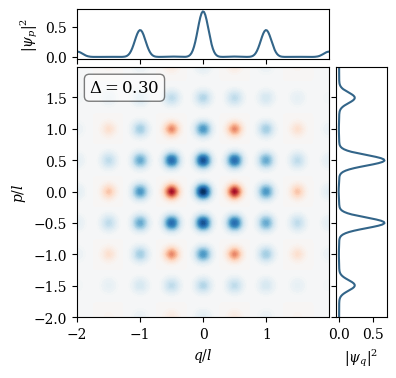

In [17]:
# Assuming W, xvec, and l are already defined
row_marginal = np.sum(W_ok, axis=0)*(xvec[1]-xvec[0])
column_marginal = np.sum(W_ok, axis=1)*(xvec[1]-xvec[0])

# Normalize the color scale
nrm = mpl.colors.Normalize(-W_ok.max(), W_ok.max())

# Create the main plot and the marginal plots
fig = plt.figure(figsize=(4, 4))
gs = fig.add_gridspec(2, 2, width_ratios=(5, 1), height_ratios=(1, 5), hspace=0.05, wspace=0.05)

# Main contour plot
ax_main = fig.add_subplot(gs[1, 0])
contour = ax_main.contourf(xvec/l, xvec/l, W_ok, 100, cmap=cm.RdBu, norm=nrm)
ax_main.set_xlabel(r'$q/l$')
ax_main.set_ylabel(r'$p/l$')

# Row marginal plot
ax_row = fig.add_subplot(gs[0, 0], sharex=ax_main)
ax_row.plot(xvec/l, row_marginal, color=blue)
ax_row.set_ylabel(r'$|\psi_p|^2$')
ax_row.xaxis.set_tick_params(labelbottom=False)

# Column marginal plot
ax_col = fig.add_subplot(gs[1, 1], sharey=ax_main)
ax_col.plot(column_marginal, xvec/l, color=blue)
ax_col.set_xlabel(r'$|\psi_q|^2$')
ax_col.yaxis.set_tick_params(labelleft=False)

# Add textbox with the value of Delta
Delta = 0.3
textstr = r'$\Delta = {0:.2f}$'.format(Delta)

props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax_main.text(0.05, 0.95, textstr, transform=ax_main.transAxes, fontsize=12,
             verticalalignment='top', bbox=props)

plt.show()

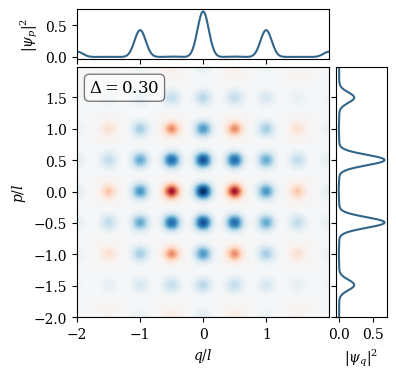

In [18]:
# Assuming W, xvec, and l are already defined
row_marginal = np.sum(W_bf, axis=0)*(xvec[1]-xvec[0])
column_marginal = np.sum(W_bf, axis=1)*(xvec[1]-xvec[0])

# Normalize the color scale
nrm = mpl.colors.Normalize(-W_bf.max(), W_bf.max())

# Create the main plot and the marginal plots
fig = plt.figure(figsize=(4, 4))
gs = fig.add_gridspec(2, 2, width_ratios=(5, 1), height_ratios=(1, 5), hspace=0.05, wspace=0.05)

# Main contour plot
ax_main = fig.add_subplot(gs[1, 0])
contour = ax_main.contourf(xvec/l, xvec/l, W_bf, 100, cmap=cm.RdBu, norm=nrm)
ax_main.set_xlabel(r'$q/l$')
ax_main.set_ylabel(r'$p/l$')

# Row marginal plot
ax_row = fig.add_subplot(gs[0, 0], sharex=ax_main)
ax_row.plot(xvec/l, row_marginal, color=blue)
ax_row.set_ylabel(r'$|\psi_p|^2$')
ax_row.xaxis.set_tick_params(labelbottom=False)

# Column marginal plot
ax_col = fig.add_subplot(gs[1, 1], sharey=ax_main)
ax_col.plot(column_marginal, xvec/l, color=blue)
ax_col.set_xlabel(r'$|\psi_q|^2$')
ax_col.yaxis.set_tick_params(labelleft=False)

# Add textbox with the value of Delta
Delta = 0.3
textstr = r'$\Delta = {0:.2f}$'.format(Delta)

props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax_main.text(0.05, 0.95, textstr, transform=ax_main.transAxes, fontsize=12,
             verticalalignment='top', bbox=props)

plt.show()

## Relaxation at all beta

In [30]:
def sBs_q_relaxation(mu, Delta, beta):
    '''
    beta between 0 and 1 (not included)
    '''
    sd, cd, td = np.sinh(Delta**2), np.cosh(Delta**2), np.tanh(Delta**2)
    large, small = -1j*l*cd, l*sd/2
    nu = (-1)**mu
    return CD(small)@I_Rx(-nu*np.pi/2)@ CD(beta * large) @ P_ge_gg  @CD((1-beta) * large)@I_Rx(np.pi/2)@CD(small)

def fidelity_after_relaxation(sensor, Delta,beta):
    
    Uq0_bf, Uq1_bf = sBs_q_relaxation(0, Delta,beta), sBs_q_relaxation(1, Delta,beta)
    Kgq0_bf, Keq0_bf = Krauss_from_U(Uq0_bf)
    Kgq1_bf, Keq1_bf = Krauss_from_U(Uq1_bf)

    Krauss_dictionary, Krauss_dictionary_U = Krauss_dictionaries(Delta)
    Kgq0, Keq0 = Krauss_dictionary_U['Kgq0'], Krauss_dictionary_U['Keq0']

    # print(np.round(qt.Qobj(Kgq0-Keq0).eigenenergies(),3))

    rho_ok_g = qt.Qobj(Kgq0 @ sensor @ Kgq0.getH())
    rho_ok_e = qt.Qobj(Keq0 @ sensor @ Keq0.getH())
    rho_bf_g = qt.Qobj(Kgq0_bf @ sensor @ Kgq0_bf.getH())
    rho_ok_g = rho_ok_g/ rho_ok_g.tr()
    rho_ok_e = rho_ok_e/ rho_ok_e.tr()
    rho_bf_g = rho_bf_g/ rho_bf_g.tr()

    F_gg = qt.fidelity(qt.Qobj(rho_ok_g), qt.Qobj(rho_bf_g))
    F_eg = qt.fidelity(qt.Qobj(rho_ok_e), qt.Qobj(rho_bf_g))
    F_bf_gg = qt.fidelity(qt.Qobj(rho_bf_g), qt.Qobj(rho_bf_g))
    return [F_gg, F_eg,F_bf_gg]

beta_range = np.linspace(0, 1, 50)
fidelities = [fidelity_after_relaxation(sensor, Delta, beta) for beta in tqdm(beta_range)]



/Users/labl2714/Projects/GKP-metrology/GKP_noise/lib/python3.10/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  return spsolve(Q, P)
/Users/labl2714/Projects/GKP-metrology/GKP_noise/lib/python3.10/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
/Users/labl2714/Projects/GKP-metrology/GKP_noise/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:602: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve


















































100%|██████████| 50/50 [01:56<00:00,  2.32s/it]


(50, 3)


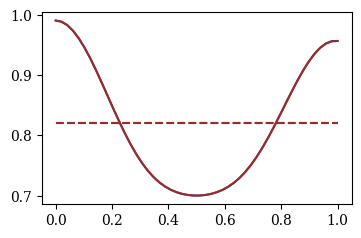

In [32]:
fig, ax = plt.subplots(figsize=(4, 2.5))
fidelities = np.array(fidelities)
print(fidelities.shape)
F_gg = fidelities[:, 0]
F_eg = fidelities[:, 1]
F_bf_gg = fidelities[:, 2]
ax.plot(beta_range, F_gg, color=blue)
ax.plot(beta_range, F_eg, color=red)
# ax.plot(beta_range, F_bf_gg, color=green, linestyle='--', label='ok ge')
# ax.plot(beta_range, F_bf_gg, color=blue, linestyle='--', label='bitflip gg')
ax.plot(beta_range, np.average(F_gg)*np.ones_like(beta_range), color=blue, linestyle='--', label='average fidelity')
ax.plot(beta_range, np.average(F_eg)*np.ones_like(beta_range), color=red, linestyle='--')
# ax.plot(beta_range, np.average(F_bf_gg)*np.ones_like(beta_range), color=light_blue, linestyle='--')

dict_figure = {}
dict_figure['fidelities'] = fidelities
dict_figure['beta_range'] = beta_range
name = 'data-relaxation-qubit'
np.savez(path_figures_data+name, **dict_figure)


## measurement probabilities after bitflip

In [21]:
def sBs_p_bitflips(mu,Delta, beta):
    #corresponds to pg \simeq (1-nu\sin(lp))/2
    sd, cd, td = np.sinh(Delta**2), np.cosh(Delta**2), np.tanh(Delta**2)
    large, small = l*cd, 1j*l*sd/2
    nu = (-1)**mu
    return CD(small)@I_Rx(nu*np.pi/2)@CD(beta * large)@I_Rx(np.pi/2)@CD(small)
    

def bitflip_Krauss_dictionary(Delta, beta):
    Uq0_bf, Uq1_bf = sBs_q_bitflips(0, Delta,beta), sBs_q_bitflips(1, Delta,beta)
    Up0_bf, Up1_bf = sBs_p_bitflips(0, Delta,beta), sBs_p_bitflips(1, Delta,beta)

    Kgq0, Keq0 = Krauss_from_U(Uq0_bf)
    Kgq1, Keq1 = Krauss_from_U(Uq1_bf)
    Kgp0, Kep0 = Krauss_from_U(Up0_bf)
    Kgp1, Kep1 = Krauss_from_U(Up1_bf)
    Krauss_dictionary = {'Kgq0':Kgq0,'Keq0':Keq0,'Kgq1':Kgq1,'Keq1':Keq1,'Kgp0':Kgp0,'Kep0':Kep0,'Kgp1':Kgp1,'Kep1':Kep1}
    Krauss_dictionary_U = {'Kgq0':Uqg @ Kgq0,'Keq0':Uqe @ Keq0,'Kgq1':Uqg @ Kgq1,'Keq1':Uqe @ Keq1,'Kgp0':Upg @ Kgp0,'Kep0':Upe @ Kep0,'Kgp1':Upg @ Kgp1,'Kep1':Upe @ Kep1}
    return Krauss_dictionary, Krauss_dictionary_U

def probability_after_bitflip(Delta, beta, rho):

    Uq0_bf, Uq1_bf = sBs_q_bitflips(0, Delta,beta), sBs_q_bitflips(1, Delta,beta)
    Up0_bf, Up1_bf = sBs_p_bitflips(0, Delta,beta), sBs_p_bitflips(1, Delta,beta)
    Kgq0_bf, Keq0_bf = Krauss_from_U(Uq0_bf)
    Kgq1_bf, Keq1_bf = Krauss_from_U(Uq1_bf)
    Kgp0_bf, Kep0_bf = Krauss_from_U(Up0_bf)
    Kgp1_bf, Kep1_bf = Krauss_from_U(Up1_bf)

    Uq0, Uq1 = sBs_q(0, Delta), sBs_q(1, Delta)
    Up0, Up1 = sBs_p(0, Delta), sBs_p(1, Delta)
    Kgq0, Keq0 = Krauss_from_U(Uq0)
    Kgq1, Keq1 = Krauss_from_U(Uq1)
    Kgp0, Kep0 = Krauss_from_U(Up0)
    Kgp1, Kep1 = Krauss_from_U(Up1)

    rho_g = Kgq0 @ rho @ Kgq0.getH()
    rho_e = Keq0 @ rho @ Keq0.getH()
    rho_bf_g = Kgq0_bf @ rho @ Kgq0_bf.getH()
    rho_bf_e = Keq0_bf @ rho @ Keq0_bf.getH()

    rho_g = rho_g/ rho_g.diagonal().sum()
    rho_e = rho_e/ rho_e.diagonal().sum()
    rho_bf_g = rho_bf_g/ rho_bf_g.diagonal().sum()
    rho_bf_e = rho_bf_e/ rho_bf_e.diagonal().sum()

    # print('type Kgq0:', type(Kgq0))
    # print('type rho_g:', type(rho_g))

    p_g_p0 = (Kgp0.getH() @ Kgp0 @ rho_g).diagonal().sum()
    p_g_p1 = (Kgp1.getH() @ Kgp1 @ rho_g).diagonal().sum()
    p_e_p0 = (Kep0.getH() @ Kep0 @ rho_e).diagonal().sum()
    p_e_p1 = (Kep1.getH() @ Kep1 @ rho_e).diagonal().sum()
    p_g_bf_p0 = (Kgp0_bf.getH() @ Kgp0_bf @ rho_bf_g).diagonal().sum()
    p_g_bf_p1 = (Kgp1_bf.getH() @ Kgp1_bf @ rho_bf_g).diagonal().sum()
    p_e_bf_p0 = (Kep0_bf.getH() @ Kep0_bf @ rho_bf_e).diagonal().sum()
    p_e_bf_p1 = (Kep1_bf.getH() @ Kep1_bf @ rho_bf_e).diagonal().sum()

    return [p_g_p0, p_g_p1, p_e_p0, p_e_p1, p_g_bf_p0, p_g_bf_p1, p_e_bf_p0, p_e_bf_p1]

def stabilizers(Delta):
    E = spsla.expm(-Delta**2*n_op)
    E_inv = spsla.inv(E.tocsc())
    return E@Tq@E_inv, E@Tp@E_inv

p0_range = (l/4) * np.arange(1,2)
beta_range = np.linspace(-1, 1,10)

all_probabilities = []
for p0 in tqdm(p0_range):
    probabilities_p0 = []
    q_op = (a_op + a_op.T)/np.sqrt(2)
    p_op = -1j*(a_op - a_op.T)/np.sqrt(2)
    beta = 1j*p0/np.sqrt(2)
    rho = Displacement(beta) @ sensor @ Displacement(beta).getH()
    print('expectation value of q:', (q_op @ rho).diagonal().sum())
    print('expectation value of p:', (p_op @ rho).diagonal().sum())
    for beta in beta_range:
        probabilities_p0.append(probability_after_bitflip(Delta, beta,rho))
    all_probabilities.append(probabilities_p0)

  0%|          | 0/1 [00:00<?, ?it/s]/Users/labl2714/Projects/GKP-metrology/GKP_noise/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:602: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/Users/labl2714/Projects/GKP-metrology/GKP_noise/lib/python3.10/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
/Users/labl2714/Projects/GKP-metrology/GKP_noise/lib/python3.10/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  return spsolve(Q, P)


expectation value of q: (5.661030330283231e-32+2.5114526886090005e-18j)
expectation value of p: (0.6266573616545461+1.6921894754945886e-31j)
expectation value of p: (0.6266573616545461+1.6921894754945886e-31j)
expectation value of p: (0.6266573616545461+1.6921894754945886e-31j)
expectation value of p: (0.6266573616545461+1.6921894754945886e-31j)
expectation value of p: (0.6266573616545461+1.6921894754945886e-31j)
expectation value of p: (0.6266573616545461+1.6921894754945886e-31j)
expectation value of p: (0.6266573616545461+1.6921894754945886e-31j)
expectation value of p: (0.6266573616545461+1.6921894754945886e-31j)
expectation value of p: (0.6266573616545461+1.6921894754945886e-31j)
expectation value of p: (0.6266573616545461+1.6921894754945886e-31j)
expectation value of p: (0.6266573616545461+1.6921894754945886e-31j)


100%|██████████| 1/1 [00:10<00:00, 10.38s/it]


(1, 10, 8)
[[[0.981886 0.018114 0.018114 0.981886 0.14186  0.85814  0.85814
   0.14186 ]
  [0.981886 0.018114 0.018114 0.981886 0.502536 0.497464 0.497464
   0.502536]
  [0.981886 0.018114 0.018114 0.981886 0.509829 0.490171 0.490171
   0.509829]
  [0.981886 0.018114 0.018114 0.981886 0.522543 0.477457 0.477457
   0.522543]
  [0.981886 0.018114 0.018114 0.981886 0.566345 0.433655 0.433655
   0.566344]
  [0.981886 0.018114 0.018114 0.981886 0.432468 0.567532 0.567532
   0.432468]
  [0.981886 0.018114 0.018114 0.981886 0.465448 0.534552 0.534552
   0.465448]
  [0.981886 0.018114 0.018114 0.981886 0.500349 0.499651 0.499651
   0.500349]
  [0.981886 0.018114 0.018114 0.981886 0.630834 0.369166 0.369166
   0.630834]
  [0.981886 0.018114 0.018114 0.981886 0.981886 0.018114 0.018114
   0.981886]]]
[[0.85814  0.497464 0.490171 0.477457 0.433655 0.567532 0.534552 0.499651
  0.369166 0.018114]]
(10,)
(10,)


(0.0, 1.0)

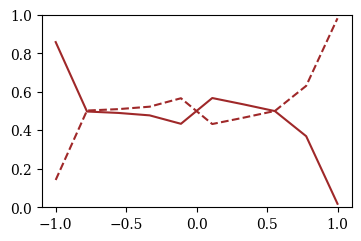

In [24]:
fig, ax = plt.subplots(figsize=(4, 2.5))
all_probabilities = np.round(np.real(np.array(all_probabilities)),6)

print(all_probabilities.shape)
print(all_probabilities)
print(all_probabilities[:,:,5])


probs_p0_0 = all_probabilities[0]
# probs_p0_1 = all_probabilities[1]
# probs_p0_2 = all_probabilities[2]
# probs_p0_3 = all_probabilities[3]
# probs_p0_4 = all_probabilities[4]

print(probs_p0_0[:,0].shape)
print(beta_range.shape)

ax.plot(beta_range, probs_p0_0[:,5], color=red, label='p_g_p0')
ax.plot(beta_range, probs_p0_0[:,4], color=red, linestyle='--', label='p_g_bf_p0')

ax.set_ylim(0,1)


# Load with new l

In [65]:
l = 2 * np.sqrt(np.pi)
#sBs with reset
def sBs_p(mu,Delta):
    #corresponds to pg \simeq (1-nu\sin(lp))/2
    sd, cd, td = np.sinh(Delta**2), np.cosh(Delta**2), np.tanh(Delta**2)
    large, small = l * cd, 1j * sd * l /2
    p5
    nu = (-1)**mu
    return CD(small)@I_Rx(nu*np.pi/2)@CD(large)@I_Rx(np.pi/2)@CD(small)
def sBs_q(mu,Delta):
    #corresponds to pg \simeq (1-nu\sin(lq))/2
    sd, cd, td = np.sinh(Delta**2), np.cosh(Delta**2), np.tanh(Delta**2)
    print(l)
    large, small = -1j*l*cd, sd * l /2
    nu = (-1)**mu
    return CD(small)@I_Rx(-nu*np.pi/2)@CD(large)@I_Rx(np.pi/2)@CD(small)

def sBs_p_measurement(mu,Delta):
    #corresponds to pg \simeq (1-nu\sin(lp))/2
    sd, cd, td = np.sinh(Delta**2), np.cosh(Delta**2), np.tanh(Delta**2)
    large, small = l*cd, 1j * sd * l /2
    print('l', l)
    nu = (-1)**mu
    return I_Rx(nu*np.pi/2)@CD(large)@I_Rx(np.pi/2)@CD(small)
def sBs_q_measurement(mu,Delta):
    #corresponds to pg \simeq (1-nu\sin(lq))/2
    sd, cd, td = np.sinh(Delta**2), np.cosh(Delta**2), np.tanh(Delta**2)
    large, small = -1j*l*cd, sd * l /2
    nu = (-1)**mu
    return I_Rx(-nu*np.pi/2)@CD(large)@I_Rx(np.pi/2)@CD(small)

def Krauss_dictionaries(Delta):
    Uq0, Uq1  = sBs_q_measurement(0,Delta), sBs_q_measurement(1,Delta)
    Up0, Up1 = sBs_p_measurement(0,Delta), sBs_p_measurement(1,Delta)

    cd, sd = np.cosh(Delta**2), np.sinh(Delta**2)
    small_p = (-1j * sd * l/2)/2/np.sqrt(2)
    small_q = (sd * l/2)/2/np.sqrt(2)
    Uqe, Uqg = Displacement(small_q), Displacement(-small_q)
    Upe, Upg = Displacement(small_p), Displacement(-small_p)

    Kgq0, Keq0 = Krauss_from_U(Uq0)
    Kgq1, Keq1 = Krauss_from_U(Uq1)
    Kgp0, Kep0 = Krauss_from_U(Up0)
    Kgp1, Kep1 = Krauss_from_U(Up1)
    Krauss_dictionary = {'Kgq0':Kgq0,'Keq0':Keq0,'Kgq1':Kgq1,'Keq1':Keq1,'Kgp0':Kgp0,'Kep0':Kep0,'Kgp1':Kgp1,'Kep1':Kep1}
    Krauss_dictionary_U = {'Kgq0':Uqg @ Kgq0,'Keq0':Uqe @ Keq0,'Kgq1':Uqg @ Kgq1,'Keq1':Uqe @ Keq1,'Kgp0':Upg @ Kgp0,'Kep0':Upe @ Kep0,'Kgp1':Upg @ Kgp1,'Kep1':Upe @ Kep1}
    return Krauss_dictionary, Krauss_dictionary_U

def sBs_cycle(Delta,R,rho0,gauges):
    #R is the number of q-p cycles
    #rho0 the initial state of the oscillator 
    #returns all density matrices and probabilities. Length of the list is R+1.

    Krauss_dictionary, Krauss_dictionary_U = Krauss_dictionaries(Delta)
    rho = rho0.copy()
    rhos = [rho.copy()]
    mu_q, mu_p = gauges[0], gauges[1] #initialize the gauges, this assures final preparation of sensor in 0,0 when starting in vacuum. 
    probs_gq, probs_gp = [], []
    for i in range(R):
        Kgq, Keq = Krauss_dictionary_U[f'Kgq{mu_q}'], Krauss_dictionary_U[f'Keq{mu_q}']
        probs_gq.append((Kgq.getH()@Kgq@rho).diagonal().sum())
        rho = Kgq @ rho @ Kgq.getH() + Keq @rho @ Keq.getH()     
        mu_p = (mu_p +1)% 2#gauge update
        
        Kgp, Kep = Krauss_dictionary_U[f'Kgp{mu_p}'], Krauss_dictionary_U[f'Kep{mu_p}']
        probs_gp.append((Kgp.getH()@Kgp@rho).diagonal().sum())
        rho = Kgp @ rho @ Kgp.getH() + Kep @rho @ Kep.getH()
        mu_q = (mu_q +1)% 2
        rhos.append(rho.copy())
    
    return rhos

# Now with the qubit instead of the qunaught

In [66]:
l = 2*np.sqrt(np.pi)
Tp = spsla.expm(1j*l*p_op)
Tq = spsla.expm(1j*l*q_op)
Dict_T = {'T1':Tq,'T2':Tp}
Delta = 0.3

rho0 = sensor.copy()
rhos = sBs_cycle(Delta, 120, rho0, [0,0])
rho_qubit = rhos[-1]

l 3.5449077018110318
l 3.5449077018110318


In [67]:
def stabilizers(Delta):
    E = spsla.expm(-Delta**2*n_op)
    E_inv = spsla.inv(E.tocsc())
    Tp = spsla.expm(1j*l*p_op)
    Tq = spsla.expm(1j*l*q_op)
    return E@Tq@E_inv, E@Tp@E_inv

Tqdelta, Tpdelta = stabilizers(Delta)
rho_qubit = qt.Qobj(rhos[-1])
print('purity:', (rho_qubit.dag()*rho_qubit).tr())
rho_qubit = qt.Qobj(rho_qubit)
Tqdelta = qt.Qobj(Tqdelta)
Tpdelta = qt.Qobj(Tpdelta)
print('expectation value q:', (Tqdelta.dag()*rho_qubit*Tqdelta).tr())
print('expectation value p:', (Tpdelta.dag()*rho_qubit*Tpdelta).tr())

purity: 0.08554659670166694
expectation value q: 10.28937282018089
expectation value p: 10.26882719069642


In [68]:
xvec = np.arange(-2*l,2*l,0.05)
W = qt.wigner(qt.Qobj(rho_qubit), xvec, xvec)

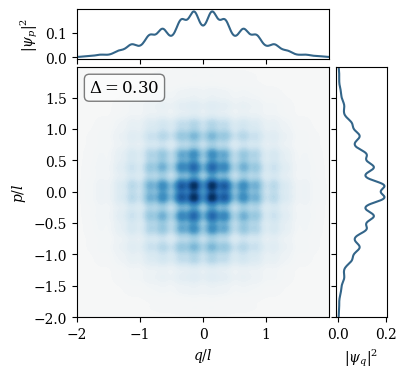

In [69]:
# Assuming W, xvec, and l are already defined
row_marginal = np.sum(W, axis=0)*(xvec[1]-xvec[0])
column_marginal = np.sum(W, axis=1)*(xvec[1]-xvec[0])

# Normalize the color scale
nrm = mpl.colors.Normalize(-W.max(), W.max())

# Create the main plot and the marginal plots
fig = plt.figure(figsize=(4, 4))
gs = fig.add_gridspec(2, 2, width_ratios=(5, 1), height_ratios=(1, 5), hspace=0.05, wspace=0.05)

# Main contour plot
ax_main = fig.add_subplot(gs[1, 0])
contour = ax_main.contourf(xvec/l, xvec/l, W, 100, cmap=cm.RdBu, norm=nrm)
ax_main.set_xlabel(r'$q/l$')
ax_main.set_ylabel(r'$p/l$')

# Row marginal plot
ax_row = fig.add_subplot(gs[0, 0], sharex=ax_main)
ax_row.plot(xvec/l, row_marginal, color=blue)
ax_row.set_ylabel(r'$|\psi_p|^2$')
ax_row.xaxis.set_tick_params(labelbottom=False)

# Column marginal plot
ax_col = fig.add_subplot(gs[1, 1], sharey=ax_main)
ax_col.plot(column_marginal, xvec/l, color=blue)
ax_col.set_xlabel(r'$|\psi_q|^2$')
ax_col.yaxis.set_tick_params(labelleft=False)

# Add textbox with the value of Delta
Delta = 0.3
textstr = r'$\Delta = {0:.2f}$'.format(Delta)

props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax_main.text(0.05, 0.95, textstr, transform=ax_main.transAxes, fontsize=12,
             verticalalignment='top', bbox=props)

plt.show()

In [27]:
def sBs_q_bitflips(mu, Delta):
    sd, cd, td = np.sinh(Delta**2), np.cosh(Delta**2), np.tanh(Delta**2)
    large, small = -1j*l*cd, l*sd/2
    nu = (-1)**mu
    return CD(small)@I_Rx(-nu*np.pi/2)@CD(-large)@I_Rx(np.pi/2)@CD(small)

Uq0_bf, Uq1_bf = sBs_q_bitflips(0, Delta), sBs_q_bitflips(1, Delta)

Kgq0_bf, Keq0_bf = Krauss_from_U(Uq0_bf) 
Kgq1_bf, Keq1_bf = Krauss_from_U(Uq1_bf)

Uq0, Uq1  = sBs_q_measurement(0,Delta), sBs_q_measurement(1,Delta)
Up0, Up1 = sBs_p_measurement(0,Delta), sBs_p_measurement(1,Delta)

cd, sd = np.cosh(Delta**2), np.sinh(Delta**2)
small_p = (-1j*l*sd/2)/2/np.sqrt(2)
small_q = (l*sd/2)/2/np.sqrt(2)
Uqe, Uqg = Displacement(small_q), Displacement(-small_q)
Upe, Upg = Displacement(small_p), Displacement(-small_p)

Kgq0, Keq0 = Krauss_from_U(Uq0)
Kgq1, Keq1 = Krauss_from_U(Uq1)
Kgp0, Kep0 = Krauss_from_U(Up0)
Kgp1, Kep1 = Krauss_from_U(Up1)
Krauss_dictionary = {'Kgq0':Kgq0,'Keq0':Keq0,'Kgq1':Kgq1,'Keq1':Keq1,'Kgp0':Kgp0,'Kep0':Kep0,'Kgp1':Kgp1,'Kep1':Kep1}
Krauss_dictionary_U = {'Kgq0':Uqg @ Kgq0,'Keq0':Uqe @ Keq0,'Kgq1':Uqg @ Kgq1,'Keq1':Uqe @ Keq1,'Kgp0':Upg @ Kgp0,'Kep0':Upe @ Kep0,'Kgp1':Upg @ Kgp1,'Kep1':Upe @ Kep1}

def simple_sBs_cycle(rho0):
    rho = rho0.copy()
    Kgq, Keq = Krauss_dictionary_U['Kgq0'], Krauss_dictionary_U['Keq0']
    Kgp, Kep = Krauss_dictionary_U['Kgp1'], Krauss_dictionary_U['Kep1']
    rho = Kgq @ rho @ Kgq.getH() + Keq @ rho @ Keq.getH()
    rho = Kgp @ rho @ Kgp.getH() + Kep @ rho @ Kep.getH()
    return rho

def simple_sBs_cycle_bf(rho0):
    rho = rho0.copy()
    rho = Kgq0_bf @ rho @ Kgq0_bf.getH() + Keq0_bf @ rho @ Keq0_bf.getH()
    rho = Kgp1 @ rho @ Kgp1.getH() + Kep1 @ rho @ Kep1.getH()
    return rho

# rho_qubit = sps.csc_matrix(rho_qubit)
rhos_ok  = sBs_cycle(Delta, 1, sps.csc_matrix(rho_qubit), [0,0])
rho_ok = rhos_ok[-1]
rho_ok2 = simple_sBs_cycle(sps.csc_matrix(rho_qubit))
rho_bf = simple_sBs_cycle_bf(sps.csc_matrix(rho_qubit))
rho_ok = qu.Qobj(rho_ok)
rho_bf = qu.Qobj(rho_bf)
print('fidelity q0:', fidelity(rho_ok, qu.Qobj(rho_ok2)))

fidelity q0: 1.0000139615618129


In [28]:
xvec = np.arange(-2*l,2*l,0.05)
W = qu.wigner(qu.Qobj(rho_qubit), xvec, xvec)
W_ok = qu.wigner(rho_ok, xvec, xvec)
W_bf = qu.wigner(rho_bf, xvec, xvec)

In [35]:
# Assuming W, xvec, and l are already defined
row_marginal = np.sum(W, axis=0)*(xvec[1]-xvec[0])
column_marginal = np.sum(W, axis=1)*(xvec[1]-xvec[0])

# Normalize the color scale
nrm = mpl.colors.Normalize(-W.max(), W.max())

# Create the main plot and the marginal plots
fig = plt.figure(figsize=(4, 4))
gs = fig.add_gridspec(2, 2, width_ratios=(5, 1), height_ratios=(1, 5), hspace=0.05, wspace=0.05)

# Main contour plot
ax_main = fig.add_subplot(gs[1, 0])
contour = ax_main.contourf(xvec/l, xvec/l, W, 100, cmap=cm.RdBu, norm=nrm)
ax_main.set_xlabel(r'$q/l$')
ax_main.set_ylabel(r'$p/l$')

# Row marginal plot
ax_row = fig.add_subplot(gs[0, 0], sharex=ax_main)
ax_row.plot(xvec/l, row_marginal, color=blue)
ax_row.set_ylabel(r'$|\psi_p|^2$')
ax_row.xaxis.set_tick_params(labelbottom=False)

# Column marginal plot
ax_col = fig.add_subplot(gs[1, 1], sharey=ax_main)
ax_col.plot(column_marginal, xvec/l, color=blue)
ax_col.set_xlabel(r'$|\psi_q|^2$')
ax_col.yaxis.set_tick_params(labelleft=False)

# Add textbox with the value of Delta
Delta = 0.3
textstr = r'$\Delta = {0:.2f}$'.format(Delta)

props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax_main.text(0.05, 0.95, textstr, transform=ax_main.transAxes, fontsize=12,
             verticalalignment='top', bbox=props)

plt.show()

NameError: name 'mpl' is not defined

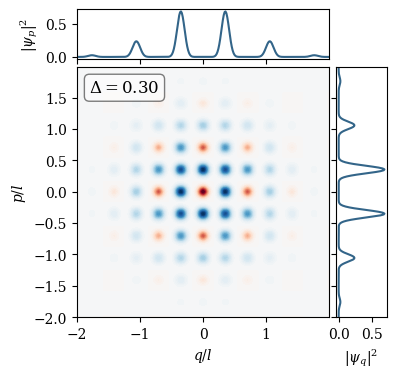

In [56]:
# Assuming W, xvec, and l are already defined
row_marginal = np.sum(W_ok, axis=0)*(xvec[1]-xvec[0])
column_marginal = np.sum(W_ok, axis=1)*(xvec[1]-xvec[0])

# Normalize the color scale
nrm = mpl.colors.Normalize(-W_ok.max(), W_ok.max())

# Create the main plot and the marginal plots
fig = plt.figure(figsize=(4, 4))
gs = fig.add_gridspec(2, 2, width_ratios=(5, 1), height_ratios=(1, 5), hspace=0.05, wspace=0.05)

# Main contour plot
ax_main = fig.add_subplot(gs[1, 0])
contour = ax_main.contourf(xvec/l, xvec/l, W_ok, 100, cmap=cm.RdBu, norm=nrm)
ax_main.set_xlabel(r'$q/l$')
ax_main.set_ylabel(r'$p/l$')

# Row marginal plot
ax_row = fig.add_subplot(gs[0, 0], sharex=ax_main)
ax_row.plot(xvec/l, row_marginal, color=blue)
ax_row.set_ylabel(r'$|\psi_p|^2$')
ax_row.xaxis.set_tick_params(labelbottom=False)

# Column marginal plot
ax_col = fig.add_subplot(gs[1, 1], sharey=ax_main)
ax_col.plot(column_marginal, xvec/l, color=blue)
ax_col.set_xlabel(r'$|\psi_q|^2$')
ax_col.yaxis.set_tick_params(labelleft=False)

# Add textbox with the value of Delta
Delta = 0.3
textstr = r'$\Delta = {0:.2f}$'.format(Delta)

props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax_main.text(0.05, 0.95, textstr, transform=ax_main.transAxes, fontsize=12,
             verticalalignment='top', bbox=props)

plt.show()